In [1]:
## installing packages
!pip install numpy pandas matplotlib seaborn scikit-learn lightgbm catboost xgboost

In [2]:
## importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import math

In [74]:
## importing the necessary data
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")

In [75]:
## Necessary functions

########## FUNCTIONS FOR INITIAL PROCESSING OF DATA ######################
## function to get the survey year
def get_survey_year(df):
    return pd.to_datetime(df["Survey_date"]).dt.year



## function to convert score ranges into equivalent grades
def scores_to_grades(df):
    cols = ["Math", "Mathlit", "Additional_lang", "Home_lang", "Science"]
    grade_dict = {
        "0 - 29 %" : "G",
        "30 - 39 %": "F",
        "40 - 49 %": "E",
        "50 - 59 %": "D",
        "60 - 69 %": "C",
        "70 - 79 %": "B",
        "80 - 100 %": "A"
    }
    
    for col in cols:
        for score_range in grade_dict.keys():
            df.loc[df[col] == score_range, col] = grade_dict[score_range]
            
            
            
## function to fill missing values with median
def fill_non_nan_median(df, col, filt_data):
    temp = df[df[filt_data[0]] == filt_data[1]][col]
    df.loc[(df[filt_data[0]] == filt_data[1]) & np.isnan(df[col]), col] = np.median(temp[~np.isnan(temp)])
    
    
            
## function to fill missing tenure values
def fill_tenure(df):
    df["Tenure_missing"] = 0
    df.loc[df["Tenure"].isna(), "Tenure_missing"] = 1
    df.loc[((df["Status"] == "studying") | (df["Status"] == "other")), "Tenure"] = 0
    fill_non_nan_median(df, "Tenure", ("Status", "wage employed"))
    fill_non_nan_median(df, "Tenure", ("Status", "unemployed"))
    fill_non_nan_median(df, "Tenure", ("Status", "self employed"))
    fill_non_nan_median(df, "Tenure", ("Status", "employment programme"))
    df.loc[df["Status"] == "wage and self employed", "Tenure"].fillna(df[df["Status"] == "wage and self employed"]["Tenure"].mean(), inplace=True)
    
    
    
## function to drop columns
def drop_cols(df, cols):
    df.drop(cols, axis = 1, inplace=True)
    
    
    
## function to engineer columns with missing values
def create_missing_feats(df, cols):
    for col in cols:
        missing_feat = f"{col}_missing"
        df[missing_feat] = 0
        df.loc[df[col].isna(), missing_feat] = 1

        
## function to missing feature values with mode
def fill_na_with_mode(df, cols):
    for col in cols:
        df[col].fillna(df[col].mode()[0], inplace=True)
        

        
## function to process data for training
def process_df(df):
    df = df.copy()
    df["Survey_year"] = get_survey_year(df) ## getting the year of survey
    scores_to_grades(df) ## converting score ranges of score columns to grades (eg. A,B...)
    fill_tenure(df) ## filling the missing tenure values
    df["Tenure"] = np.log1p(df["Tenure"]) ## taking care of skew
    create_missing_feats(df, ["Science", "Home_lang", "Mathlit",
                              "Math", "Degree", "Diploma",
                              "Schoolquintile", "Additional_lang", "Matric"
                             ])
    fill_na_with_mode(df, ["Matric", "Degree", "Diploma"]) ## filling these three columns with their modes

    drop_cols(df, [
                    "Person_id", "Survey_date", "Science", "Home_lang", "Mathlit", "Math",
                     "Schoolquintile", "Additional_lang",
                  ]) 

    return df



########## FUNCTIONS FOR INITIAL PROCESSING OF MAKING PREDICTIONS ######################
## function for prediction on test data
def make_preds(data, model, savename):
    ids = data["Person_id"]
    data = data.drop("Person_id", axis = 1)
    data[["Tenure", "Round", "Survey_year", "Birthyear", "Birthmonth"]] = scaler.transform(data[["Tenure", "Round", "Survey_year", "Birthyear", "Birthmonth"]])
    data = pd.get_dummies(data, drop_first=True)
    preds = model.predict_proba(data)
    data_df = pd.DataFrame({"Person_id": ids.values, "Target": preds[:,1]})
    data_df.to_csv(f"./{savename}.csv", index = False)

def ret_preds(data, model):
    ids = data["Person_id"]
    data = data.drop("Person_id", axis = 1)
    data["Tenure"] = scaler.transform(test[["Tenure"]])
    data = pd.get_dummies(data, drop_first=True)
    preds = model.predict_proba(data)
    return preds

def disp_confmat(model, y_true, X):
    y_pred = model.predict(X)
    disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred))
    disp.plot()

##### Reason for manner in which missing `Tenure` values were filled with the `fill_tenure` function above

Since `Tenure` probably represented how long an individual had been in their professional `Status`, I decided to fill each of the missing values taking each status as a group. <br>
And from inspection of thier distributions, I found out that:
- All individuals belonging to `studying` and `other` status all had their values missing hence, I assumed professional experience didn't apply to them and filled each of their missing values with 0.
- For the other `Status`s, upon inspection of their distributions, I found out that each of them were skewed hence the **mean** would not be a suitable representation of the distributions, hence I filled with the **medians** (except for `wage and self employed`) which proved to be better representatives of the distributions.
- The distributions are show below.

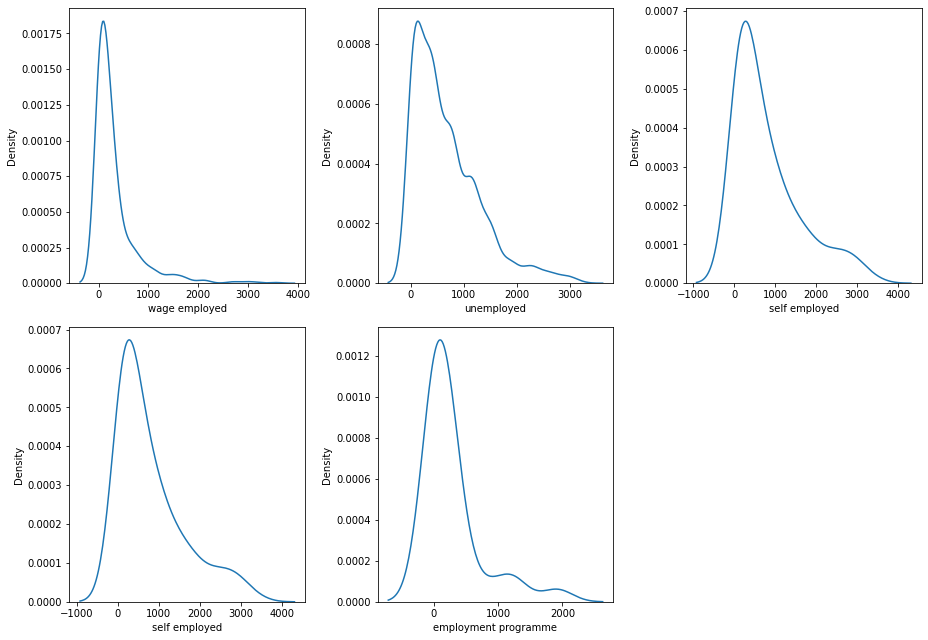

In [76]:
stat_cols = ["wage employed", "unemployed", "self employed", "employment programme", "wage and self employed"]
cols = 3 
rows = math.ceil(len(stat_cols)/cols)
fig,axes = plt.subplots(rows, cols, figsize=(13,9))

for i in range(rows):
    for j in range(cols):
        ind = i*rows + j
        if ind < len(stat_cols) - 1:
            ax = axes[i,j]
            ax.set_xlabel(stat_cols[ind])
            sns.kdeplot(train.loc[train["Status"] == stat_cols[ind], "Tenure"], ax=ax)
        else:
            axes[i,j].remove()
            
plt.tight_layout()
plt.show()

In [77]:
## processing the training dataset
train = process_df(train)

# processing the test dataset
ids = test["Person_id"]
test = process_df(test)
test = pd.concat([ids,test], axis=1)

##### Preparing Data for training

In [78]:
## importing necessary packages for training
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import xgboost

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [79]:
### preparing necessary variables for model training

## random state to use true out the model training
random_state = 42

## using stratifiedKFold to retain same proportions in train test splits as the original data
## during Grid search for hyperparameters
kf = StratifiedKFold(n_splits = 7, shuffle=True, random_state = random_state)

## Preparing scaler for normalization of numeric data
scaler = StandardScaler()
scaler.fit(train[["Tenure", "Round", "Survey_year", "Birthyear", "Birthmonth"]])

StandardScaler()

In [80]:
## Normalizing numeric features in training data
train[["Tenure", "Round", "Survey_year", "Birthyear", "Birthmonth"]] = scaler.transform(train[["Tenure", "Round", "Survey_year", "Birthyear", "Birthmonth"]])

## one-hot encoding of categorical features in training data
train = pd.get_dummies(train, drop_first=True)

In [81]:
## splitting data into features and targets
X = train.drop("Target", axis = 1)
y = train["Target"]

#### Prepating Best performing model for training

- After training data on multiple different models, `XGBClassifier`, `LGBMClassifier` and `CatBoostClassifier` produced the best results.
- Hence these three models were picked as estimators for the final `StackingClassifier` to produce the final model used.

In [82]:
## creating estimators for `Stacking Classifier`
estimators = [
    ("xgbc", xgboost.XGBClassifier(learning_rate=0.07, max_depth= 5, n_estimators=400)),
    ("lgbc", LGBMClassifier(learning_rate=0.02, max_depth= 19, n_estimators=200)),
    ("cbc", CatBoostClassifier(learning_rate=0.03, max_depth=5, n_estimators=1400, verbose = 0))
]
meta_classifier = LogisticRegression(max_iter = 10000, C=1)

#creating the model
model = StackingClassifier(estimators, final_estimator=meta_classifier, stack_method="predict_proba")

## fitting the model
model.fit(X,y)

C:\Python310\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Python310\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Python310\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Python310\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1093, number of negative: 2927
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 363
[LightGBM] [Info] Number of data points in the train set: 4020, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.271891 -> initscore=-0.985052
[LightGBM] [Info] Start training from score -0.985052


C:\Python310\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Python310\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Python310\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Python310\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
C:\Python310\lib\site-packages\xgboost\data.py:33

C:\Python310\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Python310\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Python310\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Python310\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 875, number of negative: 2341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 359
[LightGBM] [Info] Number of data points in the train set: 3216, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.272077 -> initscore=-0.984110
[LightGBM] [Info] Start training from score -0.984110
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_le

StackingClassifier(estimators=[('xgbc',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning...
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=400, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...)),
                               ('lgbc',
                                LGBMClassifier(learning_rate=0.02, max_depth=19,
                                               n_estimators=200)),
                               ('cbc',
                                <catboost.core.CatBoostClassifier object at 0x00000142F9C64F70>)],
                   final_estimator=LogisticRegression(C=1, max_iter=10000),
                   stack_method='predict_proba')

In [84]:
make_preds(test, model, "final_submission")

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


C:\Python310\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Python310\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Python310\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Python310\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
